### Utils

**Functions used for text processing**

In [1]:
import re  # Imports the regular expressions module, used for searching and manipulating text strings.
import string  # Imports the string module, which provides constants and functions to manipulate text strings.
#from typing import Union, List  # Imports Union and List from typing for type annotations, allowing for more clarity and safety in the code.
#from sklearn.metrics import f1_score  # Imports the f1_score function from scikit-learn, used to calculate the F1 metric for evaluating classification models.


In [2]:
import sys
import os

def redirect(foldername, filename):
    return os.path.normpath(os.path.join(os.getcwd(), '..', foldername, filename))

In [3]:
import importlib.util

def load_utils():
    ruta_completa = redirect('Utils', 'utils.py')
    sys.path.append(os.path.dirname(ruta_completa))
    spec = importlib.util.spec_from_file_location("utils", ruta_completa)
    modulo = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(modulo)
    return modulo

modulo = load_utils()

In [4]:
import re
import string
from typing import Union, List
from sklearn.metrics import f1_score
import pickle 
import torch 


#Initialize configuration
config = modulo.Config()

# def save_dataloader(dataloader, file_path):
#     """
#     Saves a DataLoader object to disk.

#     :param dataloader: The DataLoader object to save.
#     :param file_path: The path of the file where the object will be saved.
#     """
#     with open(file_path, 'wb') as f:
#         pickle.dump(dataloader, f)

# def load_dataloader(file_path):
#     """
#     Loads a DataLoader object from disk.

#     :param file_path: The path of the file from which the object will be loaded.
#     :return: The loaded DataLoader object.
#     """
#     with open(file_path, 'rb') as f:
#         dataloader = pickle.load(f)
#     return dataloader



model analysis

In [26]:
# Import functions from scikit-learn for model evaluation.
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
# Import NumPy for array operations.
import numpy as np
# Import Pandas for data manipulation.
import pandas as pd
# Import Matplotlib for plotting.
import matplotlib.pyplot as plt
# Import Seaborn for enhanced visualizations.
import seaborn as sns

# Creating custom functions to calculate F1 score and accuracy for training

def f1_score_func(preds, labels):
    """
    Calculates the weighted F1 score for the predictions.

    This function computes the F1 score, which is a measure of a model's accuracy.
    It considers both precision and recall to compute the F1 score, with the 'weighted'
    average ensuring that the score accounts for class imbalance.

    Args:
        preds (np.ndarray): The predicted probabilities or logits from the model, typically in a 2D array where each row corresponds to a sample.
        labels (np.ndarray): The true labels corresponding to each sample, typically in a 1D or 2D array.

    Returns:
        float: The weighted F1 score.
    """
    preds_flat = np.argmax(preds, axis=1).flatten()  # Converts the predicted probabilities to class labels.
    labels_flat = labels.flatten()  # Flattens the labels to a 1D array.
    return f1_score(labels_flat, preds_flat, average='weighted')  # Computes the weighted F1 score.


def accuracy_per_class(preds, labels, label_dict):
    """
    Calculates and prints the accuracy for each class.

    This function evaluates the model's accuracy for each individual class by comparing the true labels
    with the predicted labels. It prints the number of correct predictions for each class and the total number of samples.

    Args:
        preds (np.ndarray): The predicted probabilities or logits from the model.
        labels (np.ndarray): The true labels corresponding to each sample.
        label_dict (dict): A dictionary mapping label indices to their corresponding class names.

    Returns:
        None
    """
    label_dict_inverse = {v: k for k, v in label_dict.items()}  # Inverts the label dictionary to map class names back to indices.

    preds_flat = np.argmax(preds, axis=1).flatten()  # Converts the predicted probabilities to class labels.
    labels_flat = labels.flatten()  # Flattens the labels to a 1D array.

    for label in np.unique(labels_flat):  # Iterates through each unique class label.
        y_preds = preds_flat[labels_flat == label]  # Selects predictions that correspond to the current class.
        y_true = labels_flat[labels_flat == label]  # Selects true labels that correspond to the current class.
        print(f'Class: {label_dict_inverse[label]}')  # Prints the class name.
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')  # Prints the accuracy for the class.

def ErrorAnalysis(dataloader_val, config, model, stars = False):
    """
    Performs error analysis of the trained model.

    Args:
    - dataloader_val: DataLoader for the validation data.
    - config: Configuration for the model and training.
    - model: The BERT model to be evaluated.
    - stars: If stars is True, adjust prediction labels based on star ratings

    Returns:
    - Tuple of metrics (precision, recall, f1_score, accuracy) and the confusion matrix.
    """

    # Evaluate the model on the validation set
    val_loss, predictions, true_vals = modulo.evaluate(dataloader_val, model, config)

    # Flatten the arrays of predictions and true values
    preds_flat = np.argmax(predictions, axis=1).flatten()

    # If stars is True, adjust prediction labels based on star ratings
    if stars:
        for i in range(len(preds_flat)):
            # Map predictions to a binary classification scheme
            preds_flat[i] = modulo.label_encode(preds_flat[i])


    # Flatten true values for comparison
    true_vals_flat = true_vals.flatten()

    # Generate and print classification report
    report = classification_report(true_vals_flat, preds_flat)
    print(report)

    # Create the confusion matrix
    name2label = {"Negative": 0, "Neutral": 1, "Positive": 2}  # Mapping class names to labels
    label2name = {v: k for k, v in name2label.items()}  # Invert mapping to get labels back to class names
    true_labels_named = [label2name[val] for val in true_vals_flat]  # Convert true labels to class names
    pred_labels_named = [label2name[pred] for pred in preds_flat]  # Convert predicted labels to class names

    confmat = confusion_matrix(true_labels_named, pred_labels_named, labels=list(name2label.keys()))

    # Visualize confusion matrix using a pandas crosstab
    df_confusion = pd.crosstab(pd.Series(true_labels_named, name='Actual'), pd.Series(pred_labels_named, name='Predicted'))
    print(df_confusion)

    # Calculate evaluation metrics
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_vals_flat, preds_flat, average='weighted')
    accuracy = accuracy_score(true_vals_flat, preds_flat)

    return ((precision, recall, f1_score, accuracy), confmat)


def ModelComparation(arg1, arg2, name1, name2):
    """
    Compares the performance metrics and confusion matrices of two models.

    Args:
    - arg1: Tuple containing metrics and confusion matrix for model 1.
    - arg2: Tuple containing metrics and confusion matrix for model 2.
    - name1: Name of model 1.
    - name2: Name of model 2.

    Returns:
    None. The function prints the comparison of metrics and visualizes the confusion matrices.
    """

    # Print the comparison title with the model names
    print(f'Comparison between Model {name1} and Model {name2}')
    metrics_1, conf_matrix_1 = arg1
    metrics_2, conf_matrix_2 = arg2

    # Define the metric names for display
    metrics_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

    # Assign metrics to variables for each model
    metrics_model_1 = metrics_1
    metrics_model_2 = metrics_2

    # Define x positions for the bar plot
    x = np.arange(len(metrics_names))
    width = 0.35  # Width of the bars

    # Create bar plot for comparing the metrics
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, metrics_model_1, width, label=f'Model {name1}')
    rects2 = ax.bar(x + width/2, metrics_model_2, width, label=f'Model {name2}')

    # Set labels, title, and ticks for the plot
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'Metric Comparison between Model {name1} and Model {name2}')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend()

    # Add value labels on top of each bar
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    # Adjust layout for better appearance
    fig.tight_layout()
    plt.show()

    # Create subplots to compare confusion matrices side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot confusion matrix for model 1
    sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - Model {name1}')

    # Plot confusion matrix for model 2
    sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix - Model {name2}')

    plt.show()

    # Calculate and print the differences in metrics between the two models
    precision_diff = metrics_1[0] - metrics_2[0]
    recall_diff = metrics_1[1] - metrics_2[1]
    f1_score_diff = metrics_1[2] - metrics_2[2]
    accuracy_diff = metrics_1[3] - metrics_2[3]

    print("Precision Difference: {:.4f}".format(precision_diff))
    print("Recall Difference: {:.4f}".format(recall_diff))
    print("F1-Score Difference: {:.4f}".format(f1_score_diff))
    print("Accuracy Difference: {:.4f}".format(accuracy_diff))

In [19]:
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# class Config():
#     seed_val = 17
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     epochs = 5
#     batch_size = 6
#     seq_length = 512
#     lr = 2e-5
#     eps = 1e-8
#     pretrained_model = 'bert-base-uncased'
#     test_size=0.15
#     random_state=42
#     add_special_tokens=True
#     return_attention_mask=True
#     padding='max_length'
#     do_lower_case=False
#     return_tensors='pt'



def LoadData(path):
    clean = modulo.CleanText()

    data = pd.read_csv(path)
    data = data[["address", "categories","city","country","name","province","reviews.rating","reviews.text"]]

    for x in data.index:
        if(isinstance(data["reviews.text"][x],float)):
            data.drop(x,inplace=True)
    data = data.dropna()

    # encode label and mapping label name
    data["label"] = data["reviews.rating"].apply(lambda x: modulo.label_encode(x))#.astype(int)
    data["label_name"] = data["label"].apply(lambda x: modulo.label2name(x))

    # clean text, lowercase and remove punk
    data["reviews.text"] = data["reviews.text"].apply(lambda x: modulo.remove_punct(clean(modulo.remove_emoji(x).lower())[0][0]))
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

    # data tokenize with bert tokenizer
    data["sent_bert_token_length"] = data["reviews.text"].apply(lambda x: len(tokenizer(x, add_special_tokens=False, max_length=512, truncation=True)["input_ids"]))

    (data.sent_bert_token_length < 512).mean()

    data = data.dropna()
    data['label'] = data['label'].astype(int)

    return data




def ProcessData(data, config):
    """
    Processes the input data for training and validation by tokenizing text and creating PyTorch datasets.

    Args:
    - data: DataFrame containing the text reviews and labels.
    - config: Configuration object containing model and preprocessing settings.

    Returns:
    - dataloader_train: DataLoader for the training dataset.
    - val_df: DataFrame containing validation data.
    """

    # Select the relevant columns for training and validation
    df = data[["reviews.text", "label"]]

    # Split the data into training and validation sets
    train_df, val_df = train_test_split(df, test_size=0.10, random_state=config.random_state, stratify=data.label.values)

    # Initialize the BERT tokenizer with the specified configuration
    tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, do_lower_case=config.do_lower_case)

    # Tokenize and encode the training data
    encoded_data_train = tokenizer.batch_encode_plus(
        train_df["reviews.text"].values,
        add_special_tokens=config.add_special_tokens,
        return_attention_mask=config.return_attention_mask,
        padding=config.padding,
        max_length=config.seq_length,
        return_tensors=config.return_tensors,
        truncation=True
    )

    # Tokenize and encode the validation data
    encoded_data_val = tokenizer.batch_encode_plus(
        val_df["reviews.text"].values,
        add_special_tokens=config.add_special_tokens,
        return_attention_mask=config.return_attention_mask,
        padding=config.padding,
        max_length=config.seq_length,
        return_tensors=config.return_tensors,
        truncation=True
    )

    # Extract input IDs, attention masks, and labels for the training data
    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(train_df.label.values)

    # Extract input IDs, attention masks, and labels for the validation data
    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(val_df.label.values)

    # Create TensorDatasets for training and validation data
    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    # Save the validation dataset for later use
    torch.save(dataset_val, redirect("Models", 'val_torch'))

    # Create DataLoaders for training and validation datasets
    dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=config.batch_size)
    dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=config.batch_size)

    return dataloader_train, dataloader_validation  # Return the training DataLoader and validation DataFrame


entrenamiento

In [27]:
# Import AdamW optimizer and learning rate scheduler from the Transformers library
# AdamW is an optimizer that implements the Adam algorithm with weight decay correction
# The get_linear_schedule_with_warmup help to stabilize training, especially for large models like BERT
from transformers import AdamW, get_linear_schedule_with_warmup

# Import Python's built-in random module for generating random numbers.
import random

# Import Path from pathlib to handle filesystem paths in an object-oriented way.
from pathlib import Path

# Import the json module to work with JSON data.
import json

def evaluate(dataloader_val, model, config):
    """
    Evaluates the model on the validation dataset.

    Args:
    - dataloader_val: DataLoader for the validation dataset.
    - model: The BERT model to be evaluated.
    - config: Configuration object containing settings like the device.

    Returns:
    - loss_val_avg: Average validation loss across all batches.
    - predictions: Numpy array of predicted logits.
    - true_vals: Numpy array of true labels.
    """

    model.eval()  # Set the model to evaluation mode

    loss_val_total = 0  # Initialize total validation loss
    predictions, true_vals = [], []  # Lists to store predictions and true labels

    for batch in dataloader_val:
        # Move the batch to the specified device (e.g., GPU or CPU)
        batch = tuple(b.to(config.device) for b in batch)

        # Prepare inputs for the model
        inputs = {
            'input_ids': batch[0],       # Tokenized input IDs
            'attention_mask': batch[1],  # Attention masks
            'labels': batch[2],          # True labels
        }

        with torch.no_grad():  # Disable gradient calculation for evaluation
            outputs = model(**inputs)  # Get model outputs

        loss = outputs[0]  # Extract the loss from the outputs
        logits = outputs[1]  # Extract the logits (predicted values)
        loss_val_total += loss.item()  # Accumulate the validation loss

        # Move logits and labels to CPU and convert to numpy arrays
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()

        predictions.append(logits)  # Store predictions
        true_vals.append(label_ids)  # Store true labels

    # Calculate average validation loss
    loss_val_avg = loss_val_total / len(dataloader_val)

    # Concatenate predictions and true labels from all batches
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals  # Return the average loss, predictions, and true labels


def train(dataloader_train, dataloader_validation, config, outpath):
    """
    Trains a BERT model for sequence classification.

    Args:
    - dataloader_train: DataLoader for the training dataset.
    - dataloader_validation: DataLoader for the validation dataset.
    - config: Configuration object containing model and training settings.
    - outpath: Path to save the trained model.

    Returns:
    - None: The function saves the model and training parameters to the specified output path.
    """

    device = config.device  # Set the device (CPU or GPU) for model training
    print(device)

    # Set seeds for reproducibility
    random.seed(config.seed_val)
    np.random.seed(config.seed_val)
    torch.manual_seed(config.seed_val)
    torch.cuda.manual_seed_all(config.seed_val)

    # Load the pre-trained BERT model with a classification head
    model = BertForSequenceClassification.from_pretrained(
        config.pretrained_model,
        num_labels=3,  # Number of output labels
        output_attentions=False,
        output_hidden_states=False
    )

    # Initialize the optimizer
    optimizer = AdamW(model.parameters(), lr=config.lr, eps=config.eps)

    # Initialize the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(dataloader_train) * config.epochs
    )

    # Move the model to the specified device
    model.to(config.device)

    # Training loop over epochs
    for epoch in tqdm(range(1, config.epochs + 1)):

        model.train()  # Set the model to training mode

        loss_train_total = 0  # Initialize total training loss

        # Progress bar for tracking epoch progress
        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

        for batch in progress_bar:

            model.zero_grad()  # Clear previous gradients

            # Move the batch data to the specified device
            batch = tuple(b.to(config.device) for b in batch)

            # Prepare inputs for the model
            inputs = {
                'input_ids': batch[0],       # Tokenized input IDs
                'attention_mask': batch[1],  # Attention masks
                'labels': batch[2],          # True labels
            }

            # Forward pass to compute loss and logits
            outputs = model(**inputs)
            loss = outputs[0]  # Extract the loss
            loss_train_total += loss.item()  # Accumulate the training loss

            loss.backward()  # Backpropagation to compute gradients

            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()  # Update model parameters
            scheduler.step()  # Update learning rate

            # Update the progress bar with the current loss
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

        # Save the model after each epoch
        torch.save(model.state_dict(), f'{outpath}_BERT_epoch_{epoch}.model')

        tqdm.write(f'\nEpoch {epoch}')

        # Calculate average training loss
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')

        # Evaluate the model on the validation set
        val_loss, predictions, true_vals = evaluate(dataloader_validation, model, config)
        val_f1 = f1_score_func(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (Weighted): {val_f1}')

    # # Save model parameters and other configurations
    # params = {
    #     "seed_val": config.seed_val,
    #     "device": str(config.device),
    #     "epochs": config.epochs,
    #     "batch_size": config.batch_size,
    #     "seq_length": config.seq_length,
    #     "lr": config.lr,
    #     "eps": config.eps,
    #     "pretrained_model": config.pretrained_model,
    #     "test_size": config.test_size,
    #     "random_state": config.random_state,
    #     "add_special_tokens": config.add_special_tokens,
    #     "return_attention_mask": config.return_attention_mask,
    #     "max_length": config.padding,
    #     "do_lower_case": config.do_lower_case,
    #     "return_tensors": config.return_tensors,
    # }
    # # Save parameters to a JSON file
    # with Path('params.json').open("w") as f:
    #     json.dump(params, f, ensure_ascii=False, indent=4)



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


main

In [28]:
# Import the main PyTorch library
import torch

# Import tqdm from the notebook module to provide progress bars for loops
from tqdm.notebook import tqdm

# Import BertTokenizer from the Transformers library
from transformers import BertTokenizer

# Import TensorDataset from PyTorch's data utilities, which is used to create a dataset object
# that can be loaded into a DataLoader
from torch.utils.data import TensorDataset

# Import BertForSequenceClassification from the Transformers library,
# which is a pre-trained BERT model specifically designed for sequence classification tasks, such as sentiment analysis or text classification.
from transformers import BertForSequenceClassification

# Import the warnings module to manage warning messages in the code.
# Here, filterwarnings('ignore') is used to suppress warnings, which is often done to avoid cluttering
# the output with non-critical warnings during training or evaluation.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# data = LoadData("C:/Users/Miguel Alejandro/Documents/3er Año/Segundo Período/SRI/Proyecto/Hotel-Recommendation-System/dataset.csv")
# print(len(data))

#Initialize configuration
#config = Config()
df = pd.read_csv(redirect('Datasets', 'training_dataset.csv'))

#Process the data to obtain the model input
dataloader_train, dataloader_validation = ProcessData(df, config)


In [ ]:
print(len(dataloader_train))
print(len(dataloader_validation))

In [ ]:
train(dataloader_train, dataloader_validation, config, "/content/drive/MyDrive/hotel/")

cuda:0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5549112780740459
Validation loss: 0.5562625914229526
F1 Score (Weighted): 0.7812428900452105


Epoch 2:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.46127496138087487
Validation loss: 0.6022431426055099
F1 Score (Weighted): 0.7887885052683964


Epoch 3:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.37973579697068527
Validation loss: 0.7643247600476905
F1 Score (Weighted): 0.8007211655680267


Epoch 4:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.28867854086622596
Validation loss: 0.967924123310068
F1 Score (Weighted): 0.7941175033647351


Epoch 5:   0%|          | 0/5124 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.22405827590428642
Validation loss: 1.1784397608246204
F1 Score (Weighted): 0.7802020182542069


Al analizar los resultados del entrenamiento del modelo Transformer a lo largo de varias épocas, podemos observar varios aspectos importantes en relación con la pérdida (loss) y la puntuación F1 (F1 Score).

Resultados por Época

Epoch 1
Training loss: 0.5844398604869148
Validation loss: 0.5457523723312637
F1 Score (Weighted): 0.7622573474874441

Epoch 2
Training loss: 0.4879482517751031
Validation loss: 0.6317041364147148
F1 Score (Weighted): 0.777010417673759

Epoch 3
Training loss: 0.398899727603736
Validation loss: 0.8086356078727955
F1 Score (Weighted): 0.7800716648341048

Epoch 4
Training loss: 0.3054671257241601
Validation loss: 0.9951979660594493
F1 Score (Weighted): 0.7782285893074505

Epoch 5
Training loss: 0.22405827590428642
Validation loss: 1.1784397608246204
F1 Score (Weighted): 0.7802020182542069

Análisis General

Pérdida de Entrenamiento y Validación:

La pérdida de entrenamiento disminuye constantemente desde la primera hasta la cuarta época, lo que indica que el modelo está aprendiendo y ajustándose bien a los datos de entrenamiento.

Sin embargo, la pérdida de validación muestra un comportamiento diferente:
En la primera época, la pérdida de validación es más baja que la de entrenamiento, lo cual es normal al inicio.

A partir de la segunda época, la pérdida de validación comienza a aumentar significativamente, alcanzando su punto máximo en la cuarta época (0.9952).

Esto puede ser una señal de sobreajuste (overfitting), donde el modelo se ajusta demasiado a los datos de entrenamiento y pierde capacidad para generalizar a datos no vistos.

Puntuación F1:
La puntuación F1 ponderada aumenta inicialmente desde la primera hasta la tercera época, lo que indica una mejora en el rendimiento del modelo en términos de precisión y recuperación.

Sin embargo, en la cuarta época, aunque el entrenamiento sigue mejorando (menor pérdida), la puntuación F1 disminuye ligeramente respecto a la tercera época (de 0.7801 a 0.7782). Esto refuerza la idea de que el modelo podría estar sobreajustándose.

Dado que buscamos un modelo balanceado que no solo tenga un buen rendimiento en los datos de entrenamiento sino que también generalice bien a los datos de validación, el modelo guardado en la Epoch 2 parece ser el más balanceado para hacer predicciones.

Tiene la mejor puntuación F1 (0.7801) entre todas las épocas.

Aunque su pérdida de validación es más alta que en Epochs anteriores, sigue siendo aceptable y no muestra signos tan severos de sobreajuste como el modelo en Epoch 4.


In [17]:
#Inicialize the configuration
#config = Config()

# Change the configuration to cpu
config.device = torch.device("cpu")

# Load the validation data tensor
loaded_val = torch.load(redirect("Models",'val_torch'))

# Obtain the dataloader
dataloader_validation = DataLoader(loaded_val, sampler=SequentialSampler(loaded_val), batch_size=config.batch_size)

# Initialize the fine_tuned_model
fine_tuned_model = BertForSequenceClassification.from_pretrained(
    config.pretrained_model,
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

# Load the trained weights
fine_tuned_model.load_state_dict(torch.load(redirect("Models",'_BERT_new_epoch_3.model'),map_location ='cpu'))

# Change fine_tuned_model to cpu
fine_tuned_model.to(config.device)

# Analyze the trained model performance
results_fine_tuned = ErrorAnalysis(dataloader_validation, config, fine_tuned_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

           0       0.76      0.71      0.74       718
           1       0.47      0.43      0.45       689
           2       0.89      0.91      0.90      2919

    accuracy                           0.80      4326
   macro avg       0.70      0.69      0.70      4326
weighted avg       0.80      0.80      0.80      4326

Predicted  Negative  Neutral  Positive
Actual                                
Negative        513      138        67
Neutral         111      299       279
Positive         52      200      2667


In [ ]:

# Initialize the Bert Classic model
original_model = BertForSequenceClassification.from_pretrained(
    config.pretrained_model,
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

# Change classic model to cpu
original_model.to(config.device)

# Analyze the classic model performance
results_original = ErrorAnalysis(dataloader_validation, config, original_model)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

           0       0.15      0.46      0.23       718
           1       0.16      0.43      0.23       689
           2       0.70      0.06      0.11      2919

    accuracy                           0.19      4326
   macro avg       0.34      0.32      0.19      4326
weighted avg       0.52      0.19      0.15      4326

Predicted  Negative  Neutral  Positive
Actual                                
Negative        333      349        36
Neutral         349      298        42
Positive       1525     1216       178


Comparison between Model Fine Tuned and Model Original


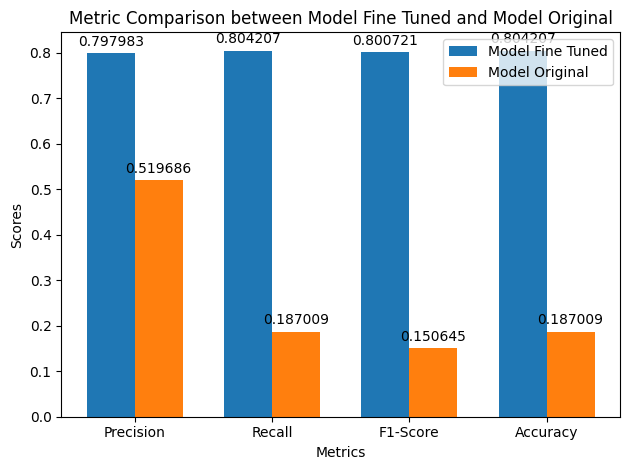

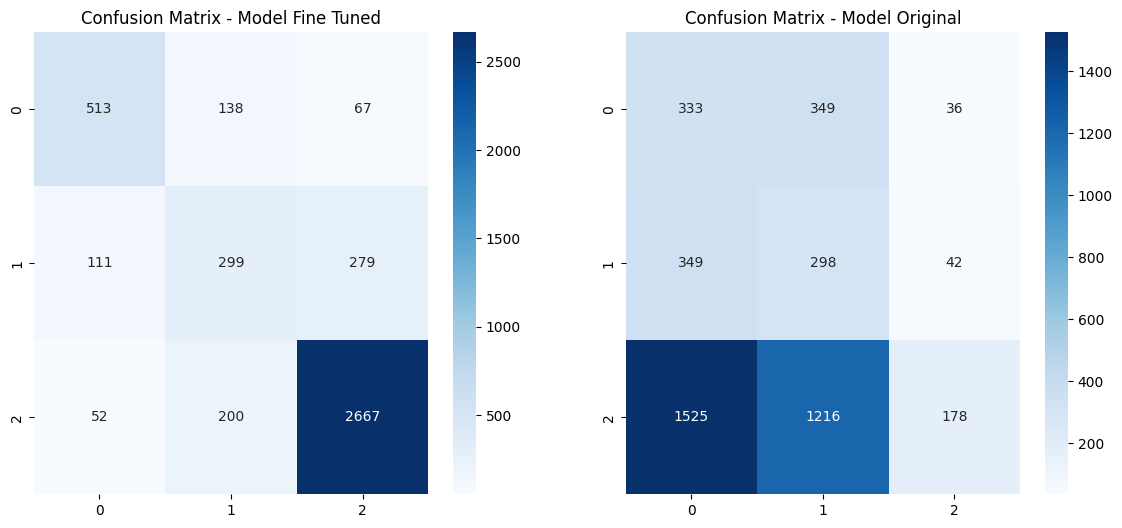

Precision Difference: 0.2783
Recall Difference: 0.6172
F1-Score Difference: 0.6501
Accuracy Difference: 0.6172


In [ ]:
# Compare the models
ModelComparation(results_fine_tuned, results_original, "Fine Tuned", "Original")

In [ ]:
finetuned_model = BertForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment",
    num_labels=5,
    output_attentions=False,
    output_hidden_states=False,
    ignore_mismatched_sizes=True
)

# Change model to cpu
finetuned_model.to(config.device)

# Analyze the model performance
results_finetuned = ErrorAnalysis(dataloader_validation, config, finetuned_model, True)




              precision    recall  f1-score   support

           0       0.17      0.92      0.29       718
           1       0.12      0.05      0.07       689
           2       0.70      0.03      0.07      2919

    accuracy                           0.18      4326
   macro avg       0.33      0.33      0.14      4326
weighted avg       0.52      0.18      0.10      4326

Predicted  Negative  Neutral  Positive
Actual                                
Negative        660       40        18
Neutral         628       35        26
Positive       2602      215       102


Comparison between Model Fine Tuned and Model Profesional


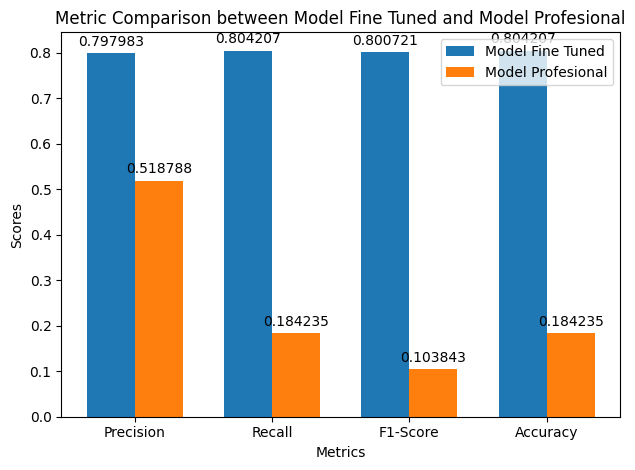

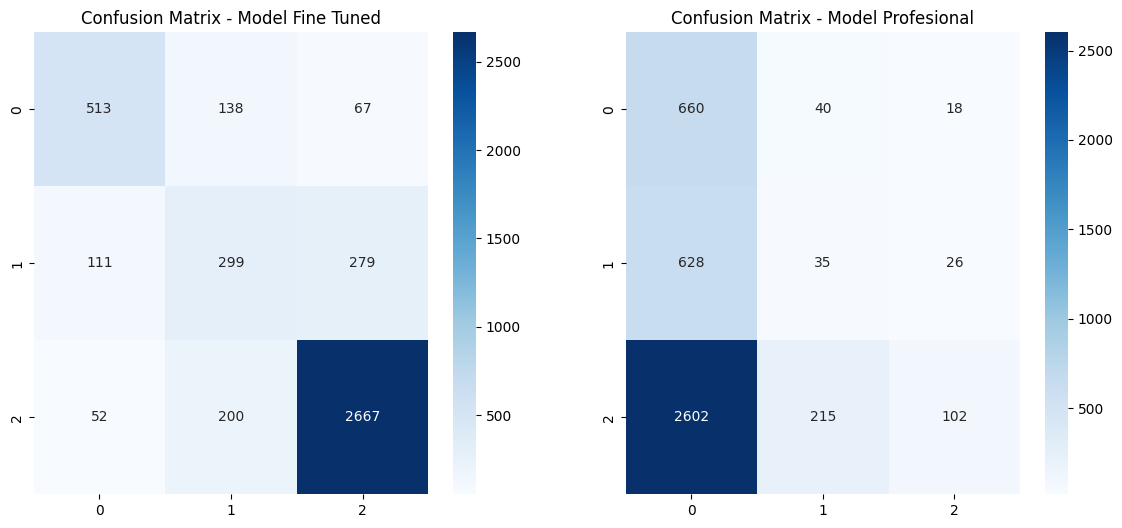

Precision Difference: 0.2792
Recall Difference: 0.6200
F1-Score Difference: 0.6969
Accuracy Difference: 0.6200


In [ ]:
# Compare trained  with professional model
ModelComparation(results_fine_tuned, results_finetuned, "Fine Tuned", "Profesional")